# **Histograma de una imagen**

Desarrollo de funciones que permitan graficar el histograma de una imagen, normalizarlo y procesarlo a partir de técnicas de manipulación de la luminancia de una imagen.

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#%matplotlib notebook
%matplotlib inline

Se definen funciones necesarias para el desarrollo del trabajo práctico:

* ***apply_matrix:*** genera el producto entre dos matrices
* ***rgb2yiq:*** convierte una imagen del espacio RGB a YIQ
* ***yiq2rgb:*** convierte una imagen del espacio YIQ a RGB
* ***plot_hist:*** grafica el histograma de una imagen
* ***plotHist_1x3:*** grafica una grilla de 1x3 con el histograma de ambas

In [2]:
# +--------------------------------------------------------------------+
# |                       PRODUCTO ENTRE MATRICES                      |
# +--------------------------------------------------------------------+
def apply_matrix(image, matrix):
    """
    Entradas:
        image  -> Array de 3-dimensiones de una imagen RGB 
                  con la forma: (alto, ancho, canales).
                  
        matrix -> Matriz de 3x3 con los valores a operar en 
                  la imagen.
    
    Salida:
        Producto matricial de 'image' y 'matrix' con la forma 
        de 'image'.
    """
    return np.matmul(image.reshape((-1,3)), matrix.T).reshape(image.shape)

# +--------------------------------------------------------------------+
# |                         CONVERSIÓN RGB -> YIQ                      |
# +--------------------------------------------------------------------+
def rgb2yiq(image):
    """
    Entrada: 
        image -> Array de 3-dimensiones de una imagen RGB 
                 con la forma: (alto, ancho, canales).
                 
                 image[..., 0] -> canal R
                 image[..., 1] -> canal G
                 image[..., 2] -> canal B
    
    Salida:
        yiq_image -> Array de 3-dimensiones de la imagen 
                     'image' en el espacio YIQ. 
        
                     yiq_image[..., 0] -> canal Y
                     yiq_image[..., 1] -> canal I
                     yiq_image[..., 2] -> canal Q
    """
    
    rgb2yiq_matrix = np.array([[0.299,       0.587,       0.114],
                               [0.59590059, -0.27455667, -0.32134392],
                               [0.21153661, -0.52273617,  0.31119955]])
    
    if image.max() > 1:
        image = image/255.0
        print("-> Convirtiendo al espacio YIQ...")
        print("   ## Reescalando la imagen en un rango de [0, 1]")
    
    yiq_image = apply_matrix(image, rgb2yiq_matrix)
    
    return yiq_image

# +--------------------------------------------------------------------+
# |                         CONVERSIÓN YIQ -> RGB                      |
# +--------------------------------------------------------------------+
def yiq2rgb(image):
    """
    Entrada: 
        image -> Array de 3-dimensiones de una imagen en el 
                 espacio YIQ con la forma: (alto, ancho, canales).
                 
                 image[..., 0] -> canal Y
                 image[..., 1] -> canal I
                 image[..., 2] -> canal Q
    
    Salida:
        rgb_image -> Array de 3-dimensiones de la imagen 
                     'image' en el espacio RGB. 
        
                     rgb_image[..., 0] -> canal R
                     rgb_image[..., 1] -> canal G
                     rgb_image[..., 2] -> canal B
    """
    
    yiq2rgb_matrix = np.array([[1,  0.9663,  0.6210],
                               [1, -0.2721, -0.6474],
                               [1, -1.1070,  1.7046]])
    
    rgb_image = np.clip(apply_matrix(image, yiq2rgb_matrix), 0, 1)
    
    return rgb_image

# +--------------------------------------------------------------------+
# |                        GRÁFICA DEL HISTOGRAMA                      |
# +--------------------------------------------------------------------+
def plot_hist(im, bins, ax, cumulative=False, bar=True):
    counts, borders = np.histogram(im if im.ndim==2 else rgb2yiq(im)[...,0], bins=bins, range=(0,1))
    if bar:
        ax.bar(range(len(counts)), np.cumsum(counts) if cumulative else counts)
    else:
        ax.plot(range(len(counts)), np.cumsum(counts) if cumulative else counts, 'orange')
    
    # Change just the subplot 'ax'
    # https://stackoverflow.com/questions/19626530/python-xticks-in-subplots
    plt.sca(ax)
    
    plt.xticks(ax.get_xticks(), labels=np.round(ax.get_xticks()/bins,2))
    plt.grid(alpha=0.3)
    plt.xlabel('Valores de luminancia (Y)')
    plt.ylabel('Cantidad de píxeles')

# +--------------------------------------------------------------------+
# |                 GRÁFICA DE 2 IMAGENES Y SU HISTOGRAMA              |
# +--------------------------------------------------------------------+
def plotHist_1x3(image1, image2, image2_process):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    axes[0].imshow(image1)
    axes[0].set_title('Original')
    axes[0].set_axis_off()

    axes[1].imshow(image2)
    axes[1].set_title(image2_process)
    axes[1].set_axis_off()

    plot_hist(image1, 40, axes[2], bar=False)
    plot_hist(image2, 40, axes[2])
    axes[2].legend(['Original', image2_process])
    axes[2].get_lines()[0].set_linewidth(2)

    plt.tight_layout()
    plt.show()

## **1. Lectura de la imagen**

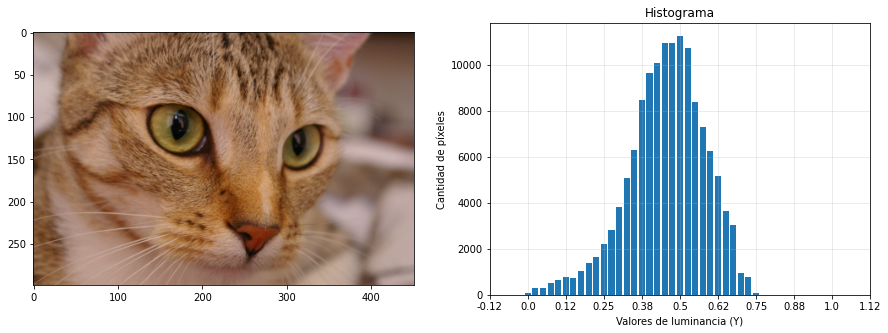

In [3]:
img_rgb = imageio.imread('imageio:chelsea.png')/255
img_gray = rgb2yiq(img_rgb)[:,:,0]

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb, 'gray', vmin=0, vmax=1)
axes[1].set_title('Histograma')
plot_hist(img_rgb, 40, axes[1])

## **2. Normalización de datos**

Se define una función que permita normalizar los valores de luminancia de una imagen.

In [4]:
def scale_img(image, scale_range=None, percentile=None, plot=True):
    """
    Entradas: 
        image       -> Matriz de una imagen a color 
                       o en escala de grises.
        
        scale_range -> Tupla con el rango en el que se
                       transforman los datos: (min, max).
        
        percentile  -> percentil 'P' para los cuales los valores
                       de los píxeles toman valor de '0'. Para el
                       percentil '100 - P' los píxeles se les 
                       asigna un valor de '1'.
                       
        plot        -> Gráfica de la imagen y su respectivo histograma.
    
    Salida:
        image_scaled -> Matriz de la nueva imagen escalada y
                        transformada dentro del ragno especificado.
    """
    # Se asegura que los valores de la imagen esten en el rango [0, 1]
    img = image/255.0 if image.max() > 1 else image
    
    # Se trabaja con la propia imagen si esta en la
    # escala de grises. De lo contrario, se escalan
    # los valores de luminancia.
    data = img if img.ndim == 2 else rgb2yiq(img)[..., 0]
    
    # Uso de percentiles
    if percentile:
        data_min = np.percentile(data, percentile)
        data_max = np.percentile(data, 100 - percentile)
    else:
        data_min = data.min(axis=0)
        data_max = data.max(axis=0)
    
    # Escala los datos
    data_std = (data - data_min) / (data_max - data_min)
    data_std = np.clip(data_std, 0, 1)
    
    # Transforma los datos a la escala (min, max) de 'scale_range'
    if scale_range:
        data_scaled = (data_std * (scale_range[1] - scale_range[0])) + scale_range[0]
    else:
        data_scaled = data_std
        
    # Imagen a blanco y negro
    if img.ndim == 2:
        image_scaled = data_scaled
    
    # Imagen a color
    else:
        img_yiq = rgb2yiq(img)
        img_yiq[..., 0] = data_scaled
        image_scaled = yiq2rgb(img_yiq)
    
    # Gráfica de la imagen y su histograma
    if plot:
        plotHist_1x3(img, image_scaled, 'Normalizada')
        
    return image_scaled

### **2.1. Rango de [0, 1]**

Se normalizan los valores de una imagen al rango [0,1]. Si la imagen es RGB, se normaliza los valores de la luminancia.

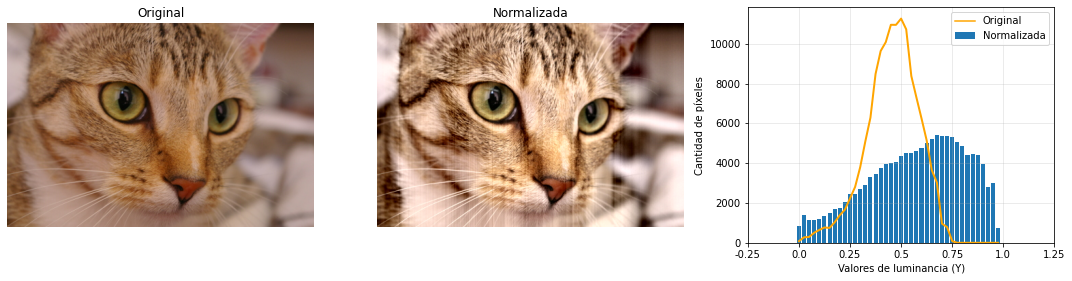

In [5]:
img_norm = scale_img(img_rgb)


### **2.2. Uso de percentiles**

Se normalizan los valores de la imagen de modo que los píxeles entre los percentiles ***0*** y ***P*** valgan '0' y los valores entre los percentiles ***100-P*** y ***100*** valgan '1'. Si la imagen es RGB, se normalizan los valores de luminancia.

#### **2.2.1. Percentil 1**

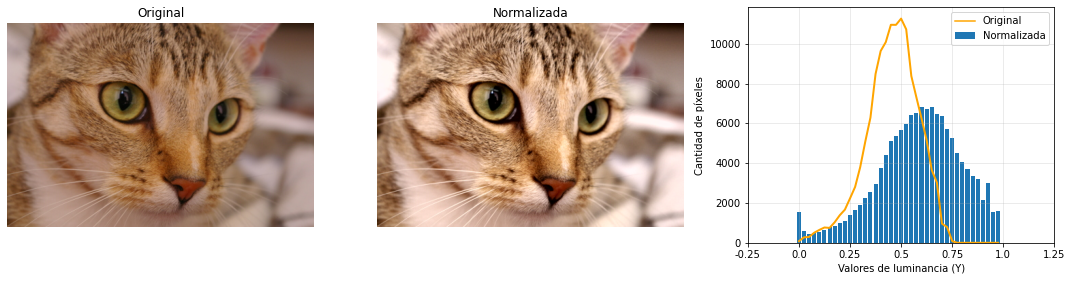

In [6]:
img_percentil1 = scale_img(img_rgb, percentile=1)

#### **2.2.2. Percentil 5**

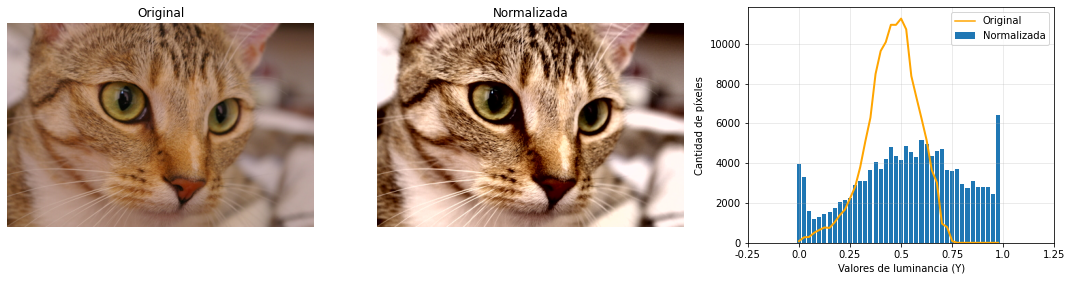

In [7]:
img_percentil5 = scale_img(img_rgb, percentile=5)

* Nótese, en los dos histogramas anteriores, cómo aumenta la cantidad de píxeles de valores '0' y '1'. Esto se observa mayormente con el percentil 5, ya que son más el segmento de valores que están acotados.

## **3. Corrección gamma: $Y_{out}=Y_{in}^\gamma$**

* Se define una función que aplique la corrección gamma a una imagen. Si la imagen es RGB, se aplica la corrección sobre la luminancia de la imagen.


* La función ***plot_filters*** genera un subplot de dos (2) columnas y una fila por cada imagen según se ingresa por parámetro. La primera columna, muestra la imagen respectiva y la segunda, su histograma.

In [8]:
def gamma_filter(image, gamma_list, percentile=None, plot=True):
    """
    Entradas: 
        image       -> Matriz de una imagen a color 
                       o en escala de grises.
        
        gamma_list  -> Lista con los valores de gamma
                       con los que se corrigen la imagen.
        
        percentile  -> Valor del percentil para normalizar
                       la imagen. Si no se ingresa alguno,
                       se normaliza en un rango de [0, 1].
        
        plot        -> Gráfica de las imagenes.
    
    Salida:
        new_images -> Diccionario cuyos 'keys' son el nombre
                      de la nueva imagen (con el valor de gamma
                      aplicado) y 'values' son la imagen corregida.
    """
    new_images = {}
    
    # Se escalan los valores de [0, 1] o usando percentiles
    img_scaled = scale_img(image, percentile=percentile, plot=False) if percentile else scale_img(image, plot=False)
    
    img_scaled_yiq = rgb2yiq(img_scaled)
    
    for gamma in gamma_list:
        new_img_yiq = img_scaled_yiq.copy()
        
        new_img_yiq[..., 0] = new_img_yiq[..., 0] ** gamma
        new_img_rgb = yiq2rgb(new_img_yiq)
        
        new_images['gamma_' + str(gamma)] = new_img_rgb
    
    # Gráfica de los resultados
    if plot:
        plot_filters(new_images)
    
    return new_images


def plot_filters(images, gamma=True):
    """
    Entradas: 
        image -> Diccionario cuyos 'keys' son el nombre 
                 de la imagen y 'values' son la imagen a
                 graficar en RGB.
                 
        gamma -> Las imagenes a mostrar son producto de
                 aplicar la corrección gamma. 
                 
                 Si es 'True', el nombre de la imagen deberá
                 ser se la forma: 'gamma_x' donde 'x' es el
                 valor de gamma aplicado.
    
    Acción:
        Subplot de dos (2) columnas y una fila por cada imagen
        en la variable 'image'.
        
        La primera columna, muestra la imagen y la segunda, su
        respectivo histograma.
    """
    rows = len(images.keys())
    fig, axes = plt.subplots(rows, 2, figsize=(10,22))

    row = 0
    for img_name, image in images.items():
        axes[row, 0].imshow(image)
        axes[row, 0].set_axis_off()
        
        plot_hist(image, 40, axes[row, 1])
        
        if gamma:
            gamma_value = img_name[6::]
            axes[row, 0].set_title('$\\gamma=$' + gamma_value, size=15)

            if gamma_value == '0.5':
                axes[row, 1].set_title('Filtro raíz cuadrada')
            elif gamma_value == '2.0':
                axes[row, 1].set_title('Filtro cuadrático')

        row += 1

    plt.tight_layout()
    plt.show()

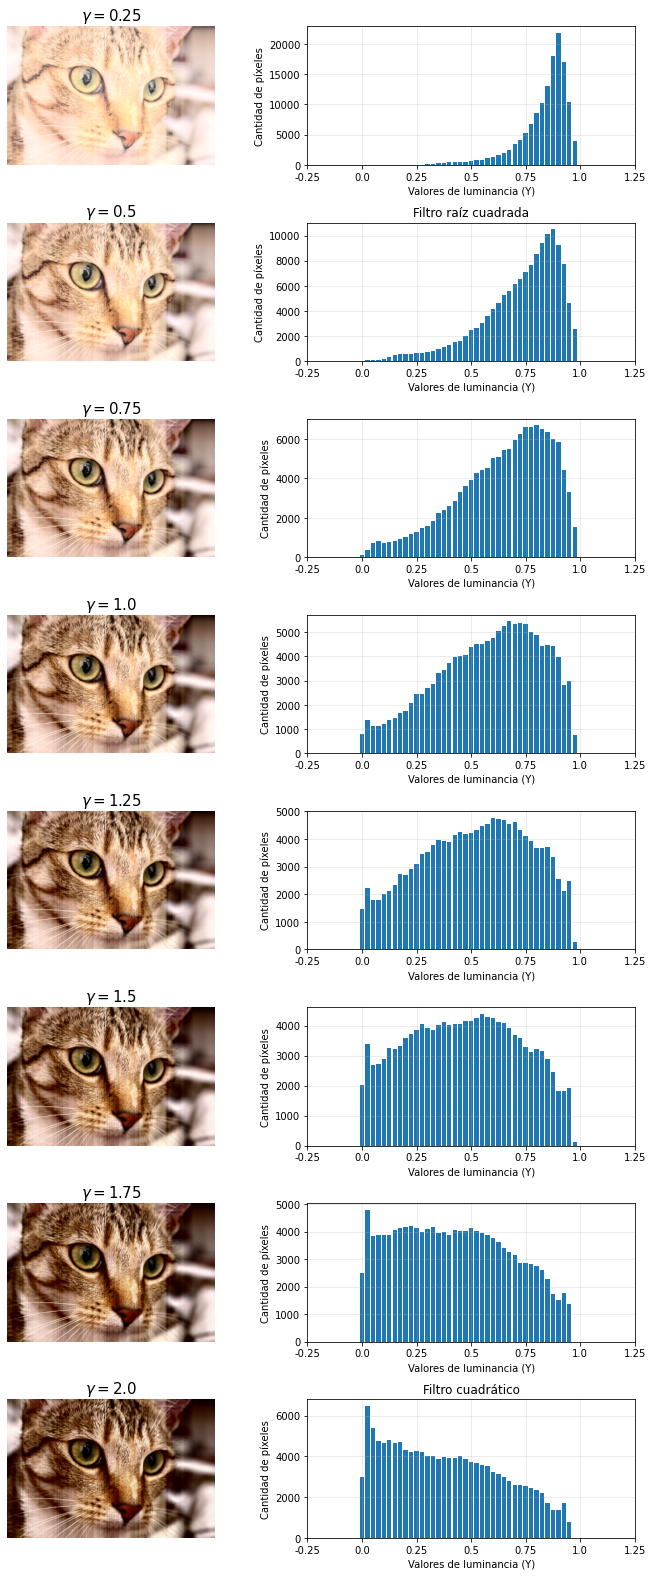

In [9]:
# Se aplica la corrección a la imagen para valores gamma de
# [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
gamma_list = np.arange(0.25, 2.25, 0.25)
images_gamma = gamma_filter(img_rgb, gamma_list=gamma_list)

* Nótese que para valores de **$\gamma<1$** la imagen se vuelve cada vez más "clara" y su histograma se sesga a la izquierda, describiendo que cada vez hay más cantidad de píxeles con luminancias cercanas a '1'.


* Por lo contrario, para cuando los valores de **$\gamma>1$** la imagen se torna más "oscura"; su histograma se sesga a la derecha y se muestra que una mayor cantidad de píxeles tienen valores inferiores a '0.5'.


* Cuando **$\gamma=1/2$** se observa el comportamiento de aplicar el **filtro de raíz cuadrada**, es decir: **$Y_{out}=\sqrt{Y_{in}}$** . En este caso se realzan los píxeles oscuros y se modifican levemente los de alta luminosidad.


* Por otro lado, cuando **$\gamma=2$** la imagen resultante es la misma al aplicar el **filtro cuadrático**, es decir: **$Y_{out}=Y_{in}^2$** . En este caso se realzan los píxeles con mayor luminosidad y se modifican levemente los oscuros.

## **4. Función a tramos (Stretch)**

* Se define una función que tome una imagen y el valor del percentil en el que se definen dos arreglos $y_{in}$ e $y_{out}$ que definen una función no-lineal en el rango $0\leq y_{in},y_{out}\leq 1$ y aplique la función a la intensidad de los pixeles de la imagen. Si la imagen es RGB debe aplicar la función a la luminosidad de la imagen.

In [10]:
def stretch(image, percentile, plot=True):
    
    # Luminancias mínima y máxima de la función a trozos
    black_out = np.percentile(image, percentile)
    white_out = np.percentile(image, 100 - percentile)
    
    # Linea a trozos
    y_in =  np.array([0.0, black_out, white_out, 1.0])
    y_out = np.array([0.0,    0.0,       1.0,    1.0])
    
    # Se identifica si la imagen es RGB o de un solo canal
    img = image if image.ndim == 2 else rgb2yiq(image)[..., 0]
    
    # Stretching
    img = np.interp(img, y_in, y_out)
    
    # Si la imagen tiene un solo canal, el resultado se deja igual
    # de lo contrario el resultado se cambia a la luminancia de la
    # imagen original
    if image.ndim == 2:
        new_image = img
    else:
        image_yiq = rgb2yiq(image)
        image_yiq[..., 0] = img
        new_image = yiq2rgb(image_yiq)
    
    if plot:
        plotHist_1x3(image, new_image, 'Stretched')
    
    return new_image

### **4.1. Stretch - Percentil 2**

* En este ejemplo se aplica la función a trozos con el percentil $P=2$ para los píxeles más oscuros. Esto quiere decir que, los valores de luminancia por debajo de ese percentil toman el valor de '0'.


* Por otro lado, para los píxeles cuyos valores de luminancia estén por encima del percentil $100-P$ se les asigna un valor de '1'.


* Finalmente, para los píxeles cuyos valores se encuentre en medio de estos dos puntos, se les aplica una interpolación según la función a trozos.

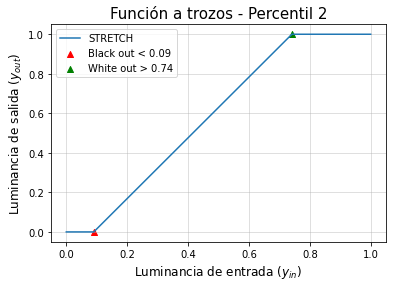

In [17]:
percentile = 2

# Luminancias mínima y máxima de la función a trozos
black_out = np.percentile(img_rgb, percentile)
white_out = np.percentile(img_rgb, 100 - percentile)

# Linea a trozos
y_in =  np.array([0.0, black_out, white_out, 1.0])
y_out = np.array([0.0,    0.0,       1.0,    1.0])

plt.plot(y_in, y_out, label='STRETCH')
plt.scatter(black_out, 0, color='red', marker='^', label='Black out < ' + str(np.round(black_out, 2)))
plt.scatter(white_out, 1, color='green', marker='^', label='White out > ' + str(np.round(white_out, 2)))

plt.title('Función a trozos - Percentil ' + str(percentile), size=15)
plt.xlabel('Luminancia de entrada $(y_{in})$', size=12)
plt.ylabel('Luminancia de salida $(y_{out})$', size=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* Según lo anterior, se obtiene lo siguiente: 

1. $Y_{in} < 0.09 \rightarrow Y_{out} = 0$

2. $Y_{in} > 0.74 \rightarrow Y_{out} = 1$

3. $0.74 < Y_{in} < 0.09 \rightarrow Y_{out}: \text{interpolación con la función a trozos}$

* La aplicación de esto, resulta en lo siguiente:

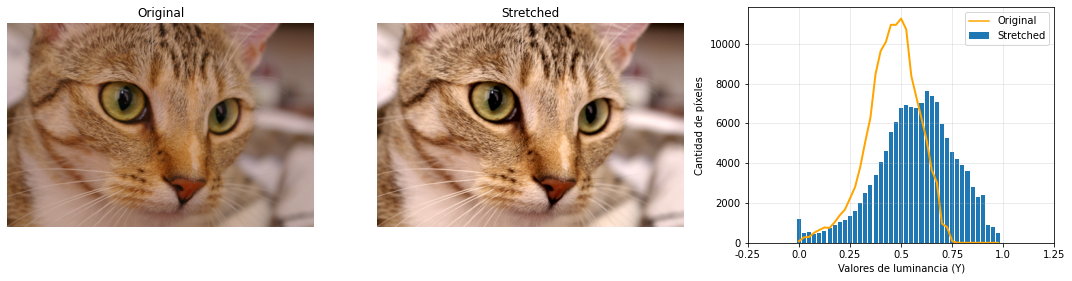

In [12]:
img_stretch1 = stretch(img_rgb, percentile=2)

## **5. Uniformalización del histograma**

Se define una función que tome una imagen y transforme su histograma de intensidades tal que presente una distribución uniforme.

In [13]:
def equalizeHist(image):
    
    # Se identifica si la imagen es RGB o de un solo canal
    img = image if image.ndim == 2 else rgb2yiq(image)[..., 0]
    
    img_histogram, bin_centers = np.histogram(img, bins=400)
    
    # Función de distribución acumulativa
    cdf = img_histogram.cumsum()
    
    # Función normalizada
    cdf_norm = cdf / cdf[-1]

    # Ecualización de la imagen
    equalize = np.interp(img, bin_centers[:-1], cdf_norm)
    
    # Si la imagen tiene un solo canal, el resultado se deja igual
    # de lo contrario el resultado se cambia a la luminancia de la
    # imagen original
    if image.ndim == 2:
        image_equalized = equalize
    else:
        image_yiq = rgb2yiq(image)
        image_yiq[..., 0] = equalize
        image_equalized = yiq2rgb(image_yiq)
    
    return image_equalized

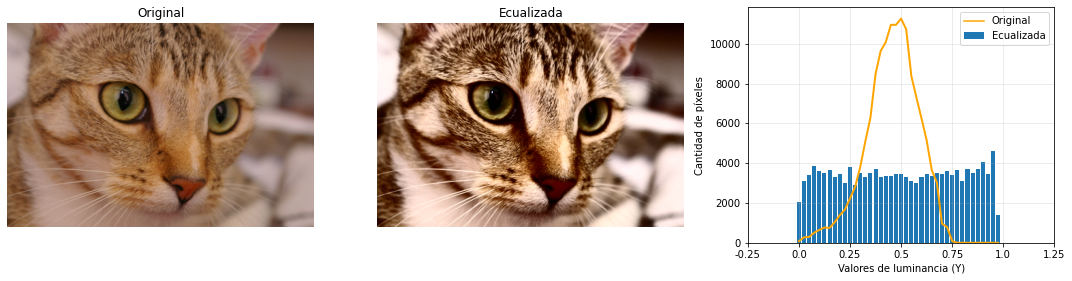

In [14]:
#image_ = images_gamma['gamma_0.25']
image_ = img_rgb
img_eq = equalizeHist(image_)

plotHist_1x3(image_, img_eq, 'Ecualizada')

## **6. Normalización del histograma**

Se define una función que tome una imagen y transforme su histograma de intensidades para que presente una distribución normal.

In [15]:
def normalizeHist(image):
    
    # Valores de observación
    x_axis = np.arange(0, 1, 1e-4)
    x_mean = 0.5
    x_std = 0.2
    
    # Se identifica si la imagen es RGB o de un solo canal
    img = image if image.ndim == 2 else rgb2yiq(image)[..., 0]

    # Normalización de la imagen
    normalize = np.interp(img, x_axis, norm.cdf(x_axis, x_mean, x_std))
    
    # Si la imagen tiene un solo canal, el resultado se deja igual
    # de lo contrario el resultado se cambia a la luminancia de la
    # imagen original
    if image.ndim == 2:
        image_normalized = normalize
    else:
        image_yiq = rgb2yiq(image)
        image_yiq[..., 0] = normalize
        image_normalized = yiq2rgb(image_yiq)
    
    return image_normalized

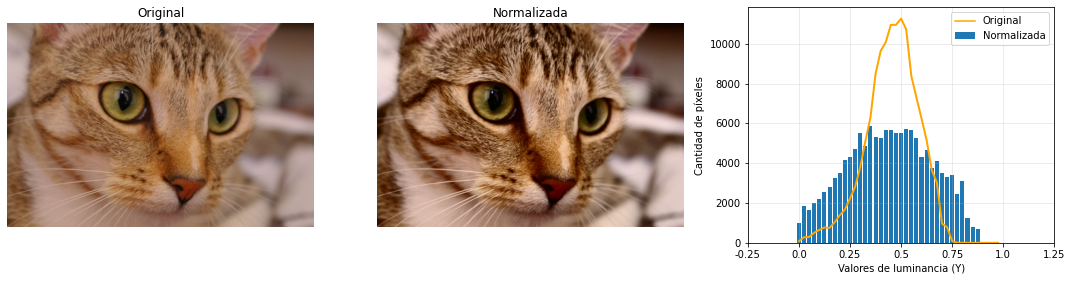

In [16]:
img_norm = normalizeHist(img_rgb)

plotHist_1x3(image_, img_norm, 'Normalizada')

# Links de ayuda

* [Aumentar el contraste en una imagen](https://stackoverflow.com/questions/48406578/adjusting-contrast-of-image-purely-with-numpy)


* [SciPy scipy.stats.norm examples](https://www.delftstack.com/es/api/scipy/scipy-scipy.stats.norm-method/)


* [Distribución de probabilidad con Python](https://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/)